<a href="https://colab.research.google.com/github/romansvintitskyy/The-Wise-Kingfishers/blob/main/checkpoint_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Checkpoint 4 Question 1: Predicting Policing Rates

In [162]:
#!pip install skforecast

## Importing Libraries


In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use('seaborn-deep')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['figure.figsize'] = (12, 8)

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 400)
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import random
seed = 12
np.random.seed(seed)
from sklearn.model_selection import train_test_split

from datetime import date
from scipy import stats

from sklearn.feature_selection import RFE
import sklearn.linear_model as sklm
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

## Importing Data

In [164]:
ts = pd.read_csv("ts_data.csv")

In [165]:
ts.dtypes

year                     int64
south_cr_per_capita    float64
north_cr_per_capita    float64
north_police_count       int64
south_police_count       int64
dtype: object

In [166]:
ts["year"] = pd.to_datetime(ts["year"], format="%Y")
ts = ts.set_index('year')
ts = ts.asfreq('12MS')

In [167]:
ts.dtypes

south_cr_per_capita    float64
north_cr_per_capita    float64
north_police_count       int64
south_police_count       int64
dtype: object

## North

In [168]:
ts_north = ts.drop(columns=['south_cr_per_capita', 'south_police_count'])
ts_north.head()


,north_cr_per_capita,north_police_count
year,,
2000-01-01,0.00,2537
2001-01-01,0.00,2558
2002-01-01,0.00,2554
2003-01-01,0.00,2535
2004-01-01,0.00,2535


In [169]:
# the dataframe displays 0.00 due to rounding but the value is not 0
ts_north.north_cr_per_capita[10]

0.0019450143856034

In [170]:
ts_north.dtypes

north_cr_per_capita    float64
north_police_count       int64
dtype: object

In [171]:
ts_north = ts_north.rename(columns={"north_cr_per_capita": "north_cr_per_10k_people"})

In [172]:
ts_north["north_cr_per_10k_people"] = 10000*ts_north["north_cr_per_10k_people"].round(4)

In [173]:
ts_north.head(18)

,north_cr_per_10k_people,north_police_count
year,,
2000-01-01,33.00,2537
2001-01-01,20.00,2558
2002-01-01,19.00,2554
2003-01-01,17.00,2535
2004-01-01,15.00,2535
2005-01-01,16.00,2524
2006-01-01,15.00,2543
2007-01-01,21.00,2504
2008-01-01,21.00,2444


In [174]:
ts_north.index

DatetimeIndex(['2000-01-01', '2001-01-01', '2002-01-01', '2003-01-01', '2004-01-01', '2005-01-01', '2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01'], dtype='datetime64[ns]', name='year', freq='12MS')

In [175]:
train_north = ts_north[ts_north.index <= '2014-01-01']
test_north = ts_north[ts_north.index > '2014-01-01']

In [176]:
(train_north.shape, test_north.shape)

((15, 2), (4, 2))

In [177]:
train_north.north_cr_per_10k_people[13]

15.0

In [178]:
train_north.north_cr_per_10k_people = np.asarray(train_north.north_cr_per_10k_people)
train_north.north_police_count = np.asarray(train_north.north_police_count)
test_north.north_cr_per_10k_people = np.asarray(test_north.north_cr_per_10k_people)
test_north.north_police_count = np.asarray(test_north.north_police_count)


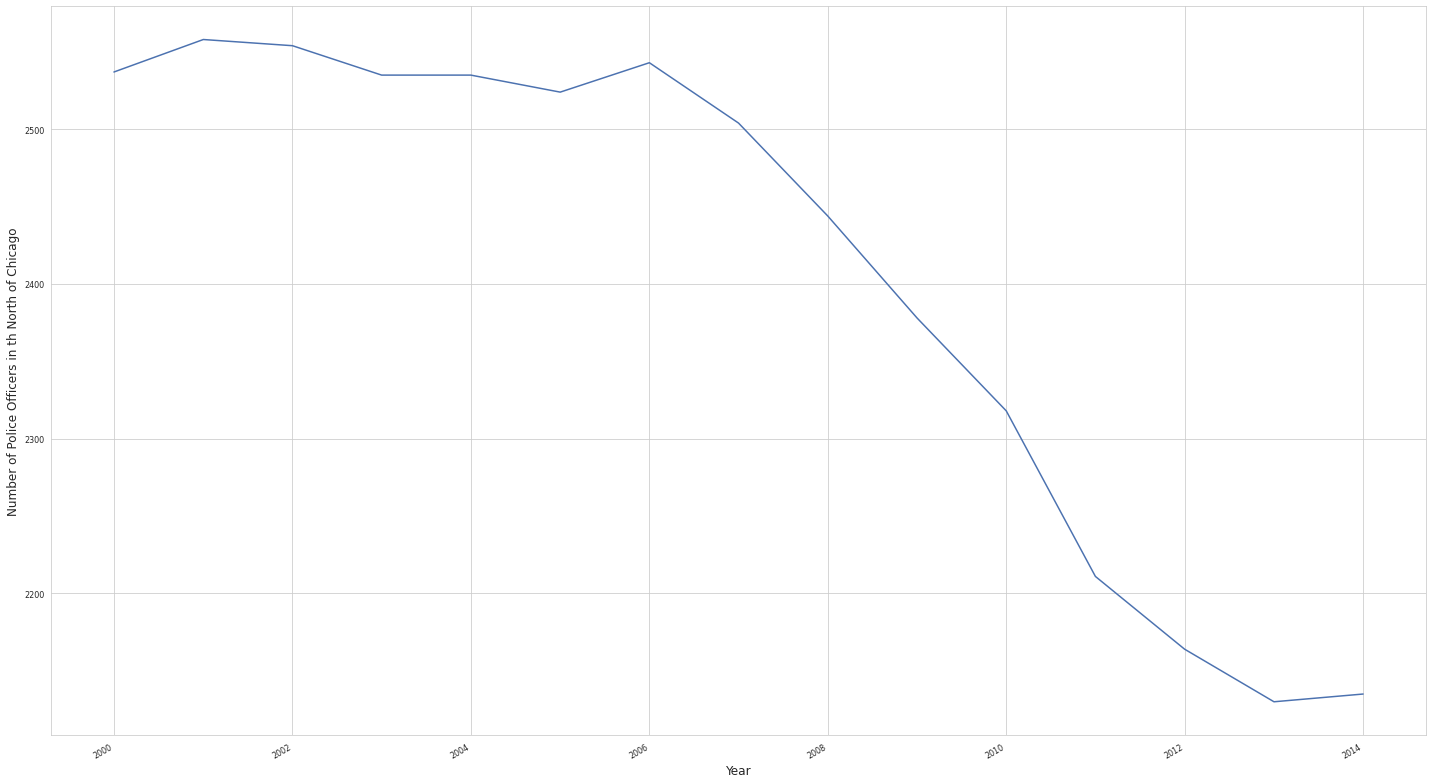

In [179]:
fig, ax = plt.subplots(figsize=(20, 11))
ax.plot(train_north['north_police_count'])
ax.set_xlabel('Year')
ax.set_ylabel('Number of Police Officers in th North of Chicago')
fig.autofmt_xdate()
plt.tight_layout()


Train dates : 2000-01-01 00:00:00 --- 2014-01-01 00:00:00  (n=15)
Test dates  : 2015-01-01 00:00:00 --- 2018-01-01 00:00:00  (n=4)


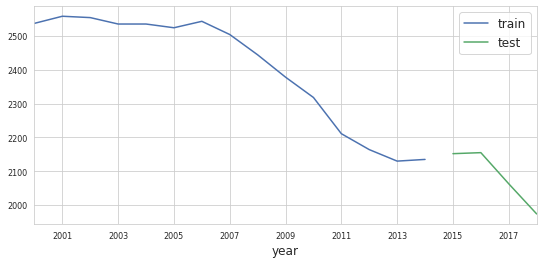

In [180]:
# Split data into train-test
# ==============================================================================
train_north = ts_north[ts_north.index <= '2014-01-01']
test_north = ts_north[ts_north.index > '2014-01-01']

print(f"Train dates : {train_north.index.min()} --- {train_north.index.max()}  (n={len(train_north)})")
print(f"Test dates  : {test_north.index.min()} --- {test_north.index.max()}  (n={len(test_north)})")

fig, ax=plt.subplots(figsize=(9, 4))
train_north['north_police_count'].plot(ax=ax, label='train')
test_north['north_police_count'].plot(ax=ax, label='test')
ax.legend();

In [181]:
# Create and train forecaster
# ==============================================================================
from sklearn.ensemble import RandomForestRegressor
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 6
             )

forecaster.fit(y=train_north['north_police_count'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2000-01-01 00:00:00'), Timestamp('2014-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: 12MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-11-18 08:37:35 
Last fit date: 2022-11-18 08:37:35 
Skforecast version: 0.5.1 
Python version: 3.7.15 

In [182]:
# Predictions
# ==============================================================================
steps = 4
predictions = forecaster.predict(steps=steps)
predictions.head()

2015-01-01   2140.35
2016-01-01   2140.35
2017-01-01   2140.35
2018-01-01   2140.35
Freq: 12MS, Name: pred, dtype: float64

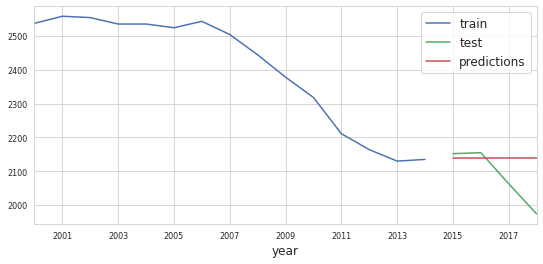

In [183]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
train_north['north_police_count'].plot(ax=ax, label='train')
test_north['north_police_count'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [184]:
predictions

2015-01-01   2140.35
2016-01-01   2140.35
2017-01-01   2140.35
2018-01-01   2140.35
Freq: 12MS, Name: pred, dtype: float64

In [185]:
# Test error
# ==============================================================================
from sklearn.metrics import mean_squared_error
error_mse = mean_squared_error(
                y_true = test_north['north_police_count'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 8501.42249999999


In [186]:
train_north.shape

(15, 2)

In [187]:
# Hyperparameter Grid search
# ==============================================================================
steps = 1
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 1 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [3, 5]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 300, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = train_north['north_police_count'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = 10,
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 18.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:37<00:00, 18.87s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 7672.044419999996



In [188]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 3
             )

forecaster.fit(y=train_north['north_police_count'])

In [189]:
# Predictions
# ==============================================================================
steps = 4
predictions = forecaster.predict(steps=steps)
predictions

2015-01-01   2135.84
2016-01-01   2135.84
2017-01-01   2135.84
2018-01-01   2135.84
Freq: 12MS, Name: pred, dtype: float64

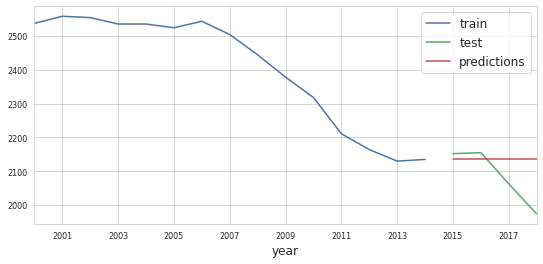

In [190]:

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
train_north['north_police_count'].plot(ax=ax, label='train')
test_north['north_police_count'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

## South

In [191]:
ts_south = ts.drop(columns=['north_cr_per_capita', 'north_police_count'])
ts_south.head()

,south_cr_per_capita,south_police_count
year,,
2000-01-01,0.00,3090
2001-01-01,0.00,3096
2002-01-01,0.00,3110
2003-01-01,0.00,3098
2004-01-01,0.00,3098


In [192]:
ts_south = ts_south.rename(columns={"south_cr_per_capita": "south_cr_per_10k_people"})
ts_south["south_cr_per_10k_people"] = 10000*ts_south["south_cr_per_10k_people"].round(4)

In [193]:
train_south = ts_south[ts_south.index <= '2014-01-01']
test_south = ts_south[ts_south.index > '2014-01-01']

train_south.south_cr_per_10k_people = np.asarray(train_south.south_cr_per_10k_people)
train_south.south_police_count = np.asarray(train_south.south_police_count)
test_south.south_cr_per_10k_people = np.asarray(test_south.south_cr_per_10k_people)
test_south.south_police_count = np.asarray(test_south.south_police_count)

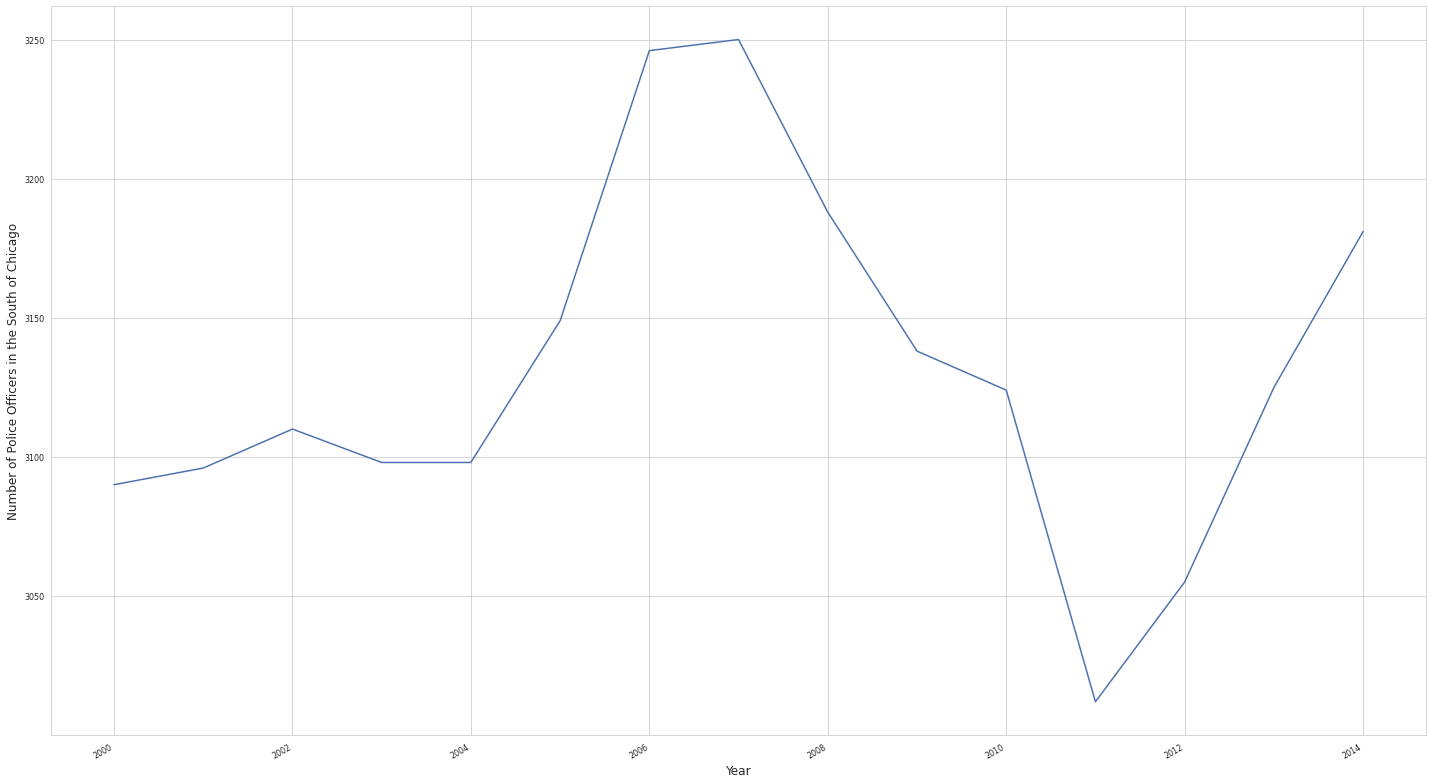

In [194]:
fig, ax = plt.subplots(figsize=(20, 11))
ax.plot(train_south['south_police_count'])
ax.set_xlabel('Year')
ax.set_ylabel('Number of Police Officers in the South of Chicago')
fig.autofmt_xdate()
plt.tight_layout()


Train dates : 2000-01-01 00:00:00 --- 2014-01-01 00:00:00  (n=15)
Test dates  : 2015-01-01 00:00:00 --- 2018-01-01 00:00:00  (n=4)


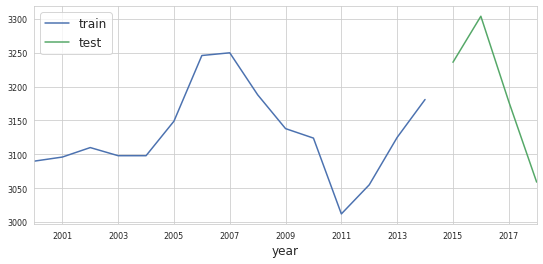

In [195]:
# Split data into train-test
# ==============================================================================
train_south = ts_south[ts_south.index <= '2014-01-01']
test_south = ts_south[ts_south.index > '2014-01-01']

print(f"Train dates : {train_south.index.min()} --- {train_south.index.max()}  (n={len(train_south)})")
print(f"Test dates  : {test_south.index.min()} --- {test_south.index.max()}  (n={len(test_south)})")

fig, ax=plt.subplots(figsize=(9, 4))
train_south['south_police_count'].plot(ax=ax, label='train')
test_south['south_police_count'].plot(ax=ax, label='test')
ax.legend();

In [196]:
# Create and train forecaster
# ==============================================================================
from sklearn.ensemble import RandomForestRegressor
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 6
             )

forecaster.fit(y=train_south['south_police_count'])
forecaster

# Predictions
# ==============================================================================
steps = 4
predictions = forecaster.predict(steps=steps)
predictions.head()

2015-01-01   3195.62
2016-01-01   3195.62
2017-01-01   3207.98
2018-01-01   3143.31
Freq: 12MS, Name: pred, dtype: float64

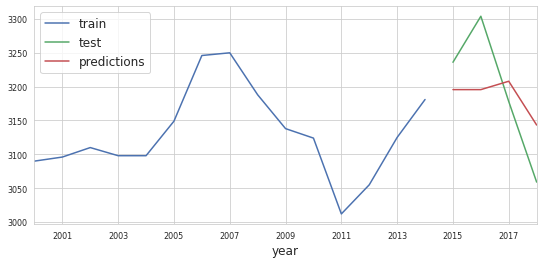

In [197]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
train_south['south_police_count'].plot(ax=ax, label='train')
test_south['south_police_count'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [198]:
# Test error
# ==============================================================================
from sklearn.metrics import mean_squared_error
error_mse = mean_squared_error(
                y_true = test_south['south_police_count'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")


Test error (mse): 5345.936325000006


In [199]:
# Hyperparameter Grid search
# ==============================================================================
steps = 1
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 1 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [3, 5]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 300, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = train_south['south_police_count'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = 10,
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 18.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:40<00:00, 20.04s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 5072.010200000008



In [200]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 3
             )

forecaster.fit(y=train_south['south_police_count'])



In [201]:
# Predictions
# ==============================================================================
steps = 4
predictions = forecaster.predict(steps=steps)
predictions


2015-01-01   3206.40
2016-01-01   3199.55
2017-01-01   3176.17
2018-01-01   3156.85
Freq: 12MS, Name: pred, dtype: float64

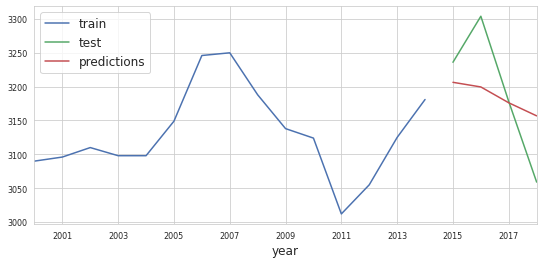

In [202]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
train_south['south_police_count'].plot(ax=ax, label='train')
test_south['south_police_count'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

##_______________

## Question 1: Extension, Understanding Importance of indivisual features

## Importing Data

In [203]:
df = pd.read_csv(
    "categorical.csv")

In [204]:
df.head()

,years,area_id,unit_name,race,officer_cnt,officer_pct,civilian_cnt,community_pct,allegations_pc_val,total_num_officers
0,2000,1548,10TH,Black,22,0.06,39440,0.33,0.00,360
1,2000,1548,10TH,White,127,0.35,4300,0.04,0.00,360
2,2000,1548,10TH,Hispanic,202,0.56,73441,0.62,0.00,360
3,2000,1546,11TH,White,215,0.55,1664,0.02,0.01,389
4,2000,1546,11TH,Native American/Alaskan Native,1,0.00,73,0.00,0.01,389


In [205]:
df = df.drop(columns=["area_id"])
df['years'] = df['years'].astype(str)


In [206]:
X = df.drop(columns=["total_num_officers"])

In [207]:
y = df[["total_num_officers"]]

In [208]:
print(X.shape)
print(X.columns)
print(y.shape)
print(y.columns)

(1501, 8)
Index(['years', 'unit_name', 'race', 'officer_cnt', 'officer_pct', 'civilian_cnt', 'community_pct', 'allegations_pc_val'], dtype='object')
(1501, 1)
Index(['total_num_officers'], dtype='object')


In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [210]:
print(X_train.shape)
print(X_train.columns)
print(y_train.shape)
print(y_train.columns)
print("______________")
print(X_test.shape)
print(X_test.columns)
print(y_test.shape)
print(y_test.columns)

(1200, 8)
Index(['years', 'unit_name', 'race', 'officer_cnt', 'officer_pct', 'civilian_cnt', 'community_pct', 'allegations_pc_val'], dtype='object')
(1200, 1)
Index(['total_num_officers'], dtype='object')
______________
(301, 8)
Index(['years', 'unit_name', 'race', 'officer_cnt', 'officer_pct', 'civilian_cnt', 'community_pct', 'allegations_pc_val'], dtype='object')
(301, 1)
Index(['total_num_officers'], dtype='object')


## EDA


In [211]:
# select numerical and categorical features
def divideFeatures(df):
    numerical_features = df.select_dtypes(include=[np.number])
    categorical_features = df.select_dtypes(include=[np.object])
    # categorical_features["years"] = df["years"]
    return numerical_features, categorical_features

In [212]:
numerical_features, categorical_features = divideFeatures(X_train)

In [213]:
numerical_features.head()

,officer_cnt,officer_pct,civilian_cnt,community_pct,allegations_pc_val
701,209,0.46,262,0.00,0.01
1342,32,0.09,19044,0.12,0.00
556,64,0.16,59671,0.85,0.01
785,110,0.28,139854,0.57,0.00
1206,1,0.00,321,0.00,0.00


In [214]:
categorical_features.head()

,years,unit_name,race
701,2008,7TH,White
1342,2016,9TH,Black
556,2007,11TH,Black
785,2009,8TH,Hispanic
1206,2015,17TH,Native American/Alaskan Native


In [215]:
print(categorical_features.shape)
print(categorical_features.columns)
print(numerical_features.shape)
print(numerical_features.columns)

(1200, 3)
Index(['years', 'unit_name', 'race'], dtype='object')
(1200, 5)
Index(['officer_cnt', 'officer_pct', 'civilian_cnt', 'community_pct', 'allegations_pc_val'], dtype='object')


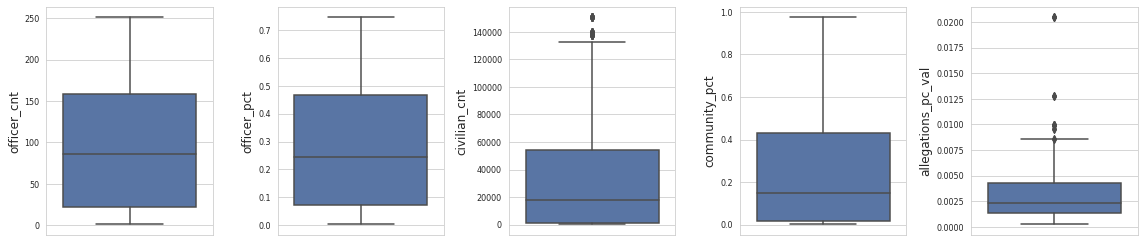

In [216]:
# boxplots of numerical features for outlier detection

fig = plt.figure(figsize=(16,30))
for i in range(len(numerical_features.columns)):
    fig.add_subplot(9, 5, i+1)
    sns.boxplot(y=numerical_features.iloc[:,i])
plt.tight_layout()
plt.show()

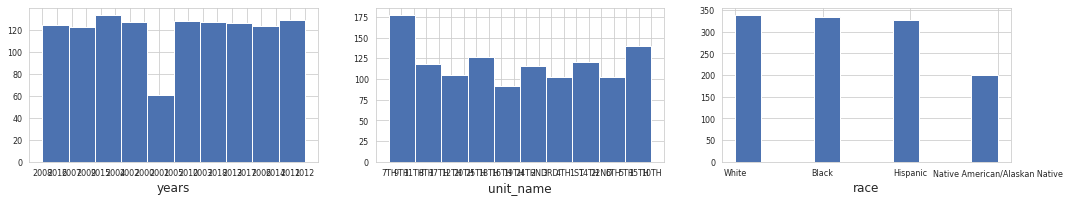

In [217]:
# distplots for categorical data

fig = plt.figure(figsize=(30,30))

for i in range(len(categorical_features.columns)):
    fig.add_subplot(9, 5, i+1)
    categorical_features.iloc[:,i].hist()
    plt.xlabel(categorical_features.columns[i])
# plt.tight_layout()
plt.show()

In [218]:
# discrete_features=[feature for feature in list(numerical_features.columns) if numerical_features[feature].unique().shape[0]<25]
# fig = plt.figure(figsize=(16,30))
# for i,feature in enumerate(discrete_features):
#     fig.add_subplot(6, 3, i+1)
#     data=df.copy()
#     data.groupby(feature)['total_num_officers'].median().plot.bar()
#     plt.xlabel(feature)
#     plt.ylabel('total_num_officers')
#     plt.title(feature)
# plt.tight_layout()
# plt.show()

In [219]:
## Missing values
print(X_train.isnull().values.any())
print(pd.isna(X_train).sum())

False
years                 0
unit_name             0
race                  0
officer_cnt           0
officer_pct           0
civilian_cnt          0
community_pct         0
allegations_pc_val    0
dtype: int64


## Checking for model assumptions

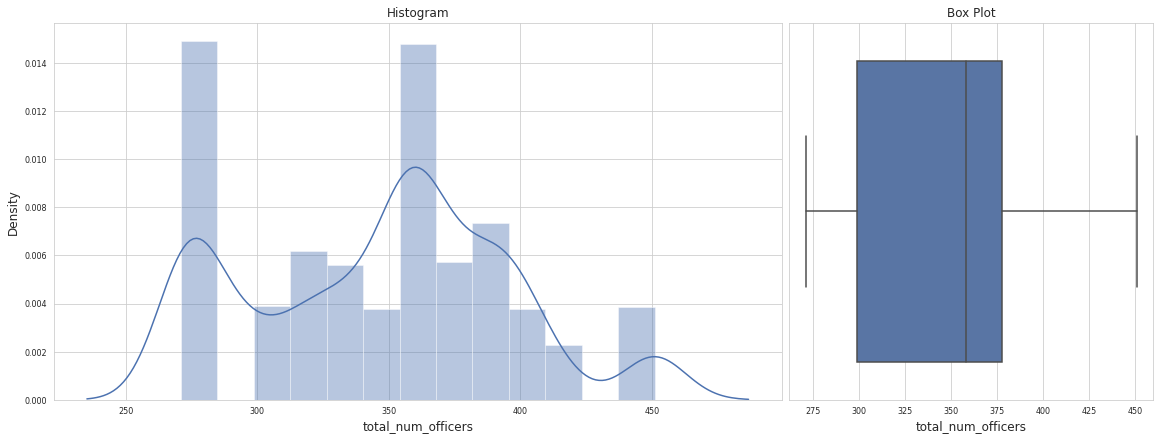

In [220]:
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(16,6))
grid = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
ax1 = fig.add_subplot(grid[0, :2])
ax1.set_title('Histogram')
sns.distplot(y_train.loc[:,'total_num_officers'], norm_hist=True, ax = ax1)
ax3 = fig.add_subplot(grid[:, 2])
ax3.set_title('Box Plot')
sns.boxplot(y_train.loc[:,'total_num_officers'], orient='v', ax = ax3)
plt.show()

### It's almost normally distributed, but have to deal with outliers

In [221]:
# Bivariate analysis

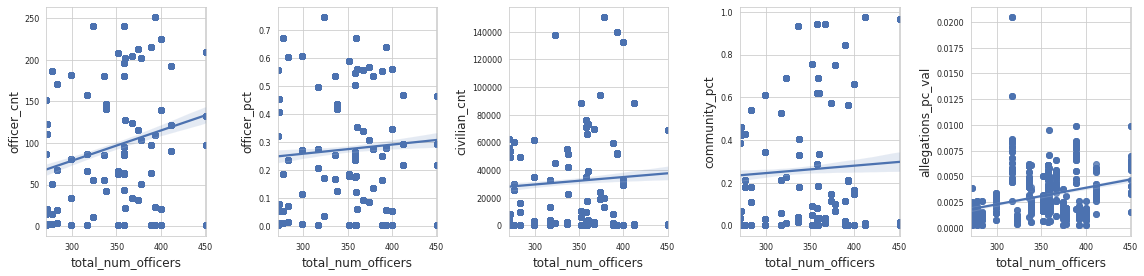

In [222]:
# scatterplot for correlation analysis of features with total_num_officers

fig = plt.figure(figsize=(16,30))
for i in range(len(numerical_features.columns)):
    fig.add_subplot(8, 5, i+1)
    sns.regplot(x=y_train['total_num_officers'],y=numerical_features.iloc[:,i])
plt.tight_layout()
plt.show()

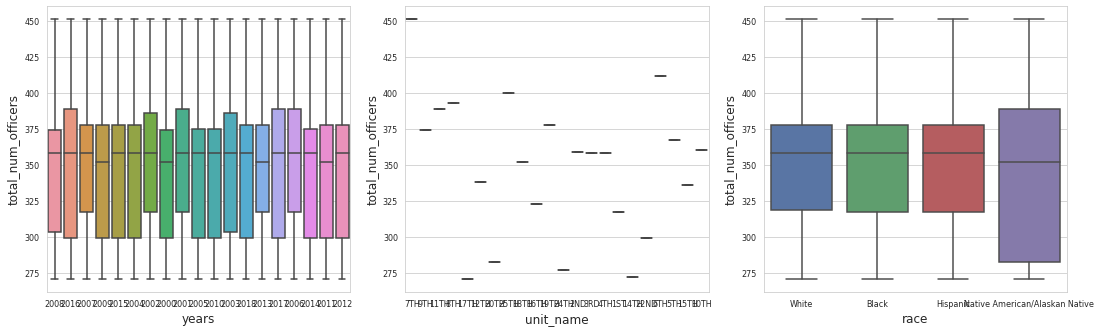

In [223]:
# boxplot for distribution analysis of categorical features with SalePrice

fig = plt.figure(figsize=(20,50))
for i in range(len(categorical_features.columns)):
    fig.add_subplot(11, 4, i+1)
    sns.boxplot(y=y_train['total_num_officers'],x=categorical_features.iloc[:,i])
plt.tight_layout()
plt.show()

In [224]:
## Multivariate analysis

In [225]:
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

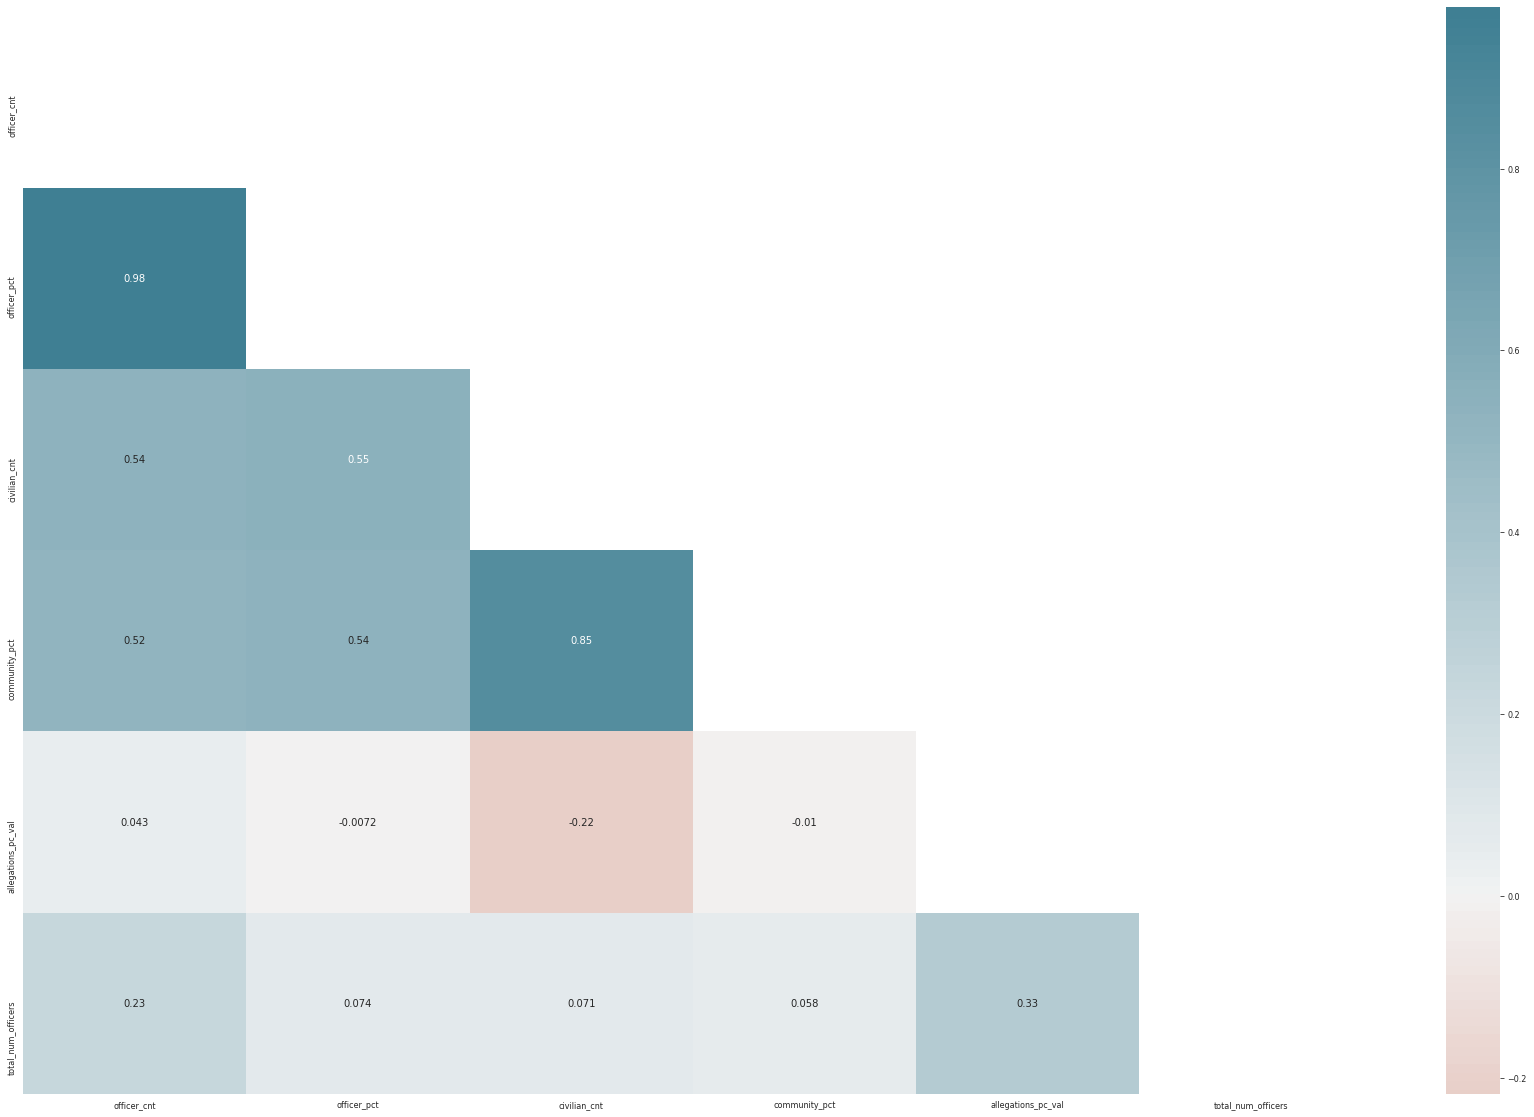

In [226]:
plt.figure(figsize = (30,20))

mask = np.zeros_like(df_train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_train.corr(), cmap=sns.diverging_palette(20, 220, n=200), mask = mask, annot=True, center = 0)
plt.show()

## Data cleaning

In [227]:
X_train.columns

Index(['years', 'unit_name', 'race', 'officer_cnt', 'officer_pct', 'civilian_cnt', 'community_pct', 'allegations_pc_val'], dtype='object')

In [228]:
print(df_train.shape)
df_train.drop_duplicates(inplace=True)
print(df_train.shape)

(1200, 9)
(1200, 9)


In [229]:
# We checked for null values earlier, no duplicates detected, all preliminary irrelevant columns dropped 

## Data Prep

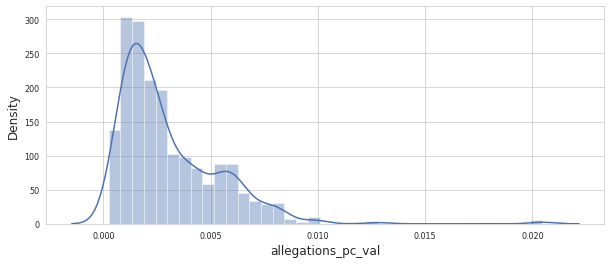

In [230]:
# plot sample skewed feature
plt.figure(figsize=(10,4))
sns.distplot(df_train["allegations_pc_val"])
plt.show()

In [231]:
# extract all skewed features
temp_numerical_features, temp_categorical_features = divideFeatures(df_train)
skewed_features = temp_numerical_features.apply(lambda x: x.skew()).sort_values(ascending=False)

In [232]:
skewed_features

allegations_pc_val   2.12
civilian_cnt         1.36
community_pct        1.03
officer_cnt          0.40
officer_pct          0.39
total_num_officers   0.05
dtype: float64

In [233]:
# transform skewed features
for feat in skewed_features.index:
    if skewed_features.loc[feat] > 0.5:
        df_train[feat] = stats.boxcox(df_train[feat])[0]
        df_test[feat] = stats.boxcox(df_test[feat])[0]

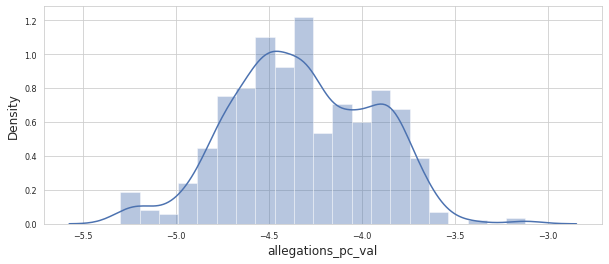

In [234]:
# plot sample skewed feature
plt.figure(figsize=(10,4))
sns.distplot(df_train["allegations_pc_val"])
plt.show()

In [235]:
upd_numerical_features, upd_categorical_features = divideFeatures(df_train)
upd_skewed_features = upd_numerical_features.apply(lambda x: x.skew()).sort_values(ascending=False)

In [236]:
upd_skewed_features

officer_cnt           0.40
officer_pct           0.39
total_num_officers    0.05
allegations_pc_val   -0.01
community_pct        -0.20
civilian_cnt         -0.22
dtype: float64

In [237]:
# outlier treatment for categorical features
def getCategoricalSkewed(categories, threshold):
    tempSkewedFeatures = []
    for feat in categories:
        for featValuePerc in list(df_train[feat].value_counts()/df_train.shape[0]):
            if featValuePerc > threshold:
                tempSkewedFeatures.append(feat)
    return list(set(tempSkewedFeatures))

# display all categorical skewed features which have value_counts > 90%
categoricalSkewed = getCategoricalSkewed(temp_categorical_features.columns, .90)
for feat in categoricalSkewed:
    print(df_train[feat].value_counts()/len(df_train))
    print()


In [238]:
# There are no highly skewed categorical variables

## Dummy Variables

In [239]:
# extract numerical and categorical for dummy and scaling later
numerical_features, categorical_features = divideFeatures(X_train)
for feat in categorical_features.columns:
    dummyVars = pd.get_dummies(X_train[feat], drop_first=True, prefix=feat+"_")
    X_train = pd.concat([X_train, dummyVars], axis=1)
    X_train.drop(feat, axis=1, inplace=True)

    dummyVars_test = pd.get_dummies(X_test[feat], drop_first=True, prefix=feat+"_")
    X_test = pd.concat([X_test, dummyVars_test], axis=1)
    X_test.drop(feat, axis=1, inplace=True)


In [240]:
X_train.shape

(1200, 47)

In [241]:
X_test.shape

(301, 47)

## Feature Scaling

In [242]:
scaler = skp.StandardScaler()

num_feat = list(numerical_features.columns)
# num_feat = []
# for i in range(len(numdd)):
#   num_feat.append(numdd[i])
# num_feat.remove('total_num_officers')

# apply scaling to all numerical variables except dummy variables as they are already between 0 and 1
X_train[num_feat] = scaler.fit_transform(X_train[num_feat])

# scale test data with transform()
X_test[num_feat] = scaler.transform(X_test[num_feat])

df_test[num_feat] = scaler.transform(df_test[num_feat])


# view sample data
X_train.describe()

,officer_cnt,officer_pct,civilian_cnt,community_pct,allegations_pc_val,years__2001,years__2002,years__2003,years__2004,years__2005,years__2006,years__2007,years__2008,years__2009,years__2010,years__2011,years__2012,years__2013,years__2014,years__2015,years__2016,years__2017,years__2018,unit_name__11TH,unit_name__12TH,unit_name__14TH,unit_name__15TH,unit_name__16TH,unit_name__17TH,unit_name__18TH,unit_name__19TH,unit_name__1ST,unit_name__20TH,unit_name__22ND,unit_name__24TH,unit_name__25TH,unit_name__2ND,unit_name__3RD,unit_name__4TH,unit_name__5TH,unit_name__6TH,unit_name__7TH,unit_name__8TH,unit_name__9TH,race__Hispanic,race__Native American/Alaskan Native,race__White
count,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00,1200.00
mean,0.00,-0.00,-0.00,0.00,-0.00,0.05,0.05,0.05,0.06,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.06,0.06,0.05,0.05,0.04,0.05,0.04,0.04,0.05,0.05,0.04,0.05,0.05,0.05,0.05,0.05,0.04,0.05,0.03,0.04,0.03,0.05,0.05,0.04,0.27,0.17,0.28
std,1.00,1.00,1.00,1.00,1.00,0.22,0.22,0.22,0.23,0.22,0.22,0.21,0.21,0.23,0.22,0.22,0.23,0.21,0.22,0.23,0.23,0.23,0.23,0.22,0.19,0.22,0.20,0.19,0.22,0.22,0.19,0.21,0.22,0.23,0.23,0.22,0.20,0.22,0.18,0.19,0.18,0.22,0.21,0.20,0.45,0.37,0.45
min,-1.24,-1.26,-0.86,-0.88,-1.18,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,-0.97,-0.94,-0.83,-0.83,-0.71,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,-0.13,-0.13,-0.39,-0.39,-0.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.82,0.90,0.59,0.57,0.52,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00
max,2.04,2.19,3.18,2.41,7.34,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


## RFE Feature Selection

In [243]:
# Running RFE to extract top features
lm = sklm.LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm)
rfe = rfe.fit(X_train, y_train)
rfeCols = X_train.columns[rfe.support_]
X_train_rfe = X_train[rfeCols]
X_test_rfe = X_test[rfeCols]
print("Selected features by RFE are: ",list(rfeCols))
print("The number of features selected by RFE is: ", len(list(rfeCols)))

Selected features by RFE are:  ['unit_name__11TH', 'unit_name__12TH', 'unit_name__14TH', 'unit_name__15TH', 'unit_name__16TH', 'unit_name__17TH', 'unit_name__18TH', 'unit_name__19TH', 'unit_name__1ST', 'unit_name__20TH', 'unit_name__22ND', 'unit_name__24TH', 'unit_name__25TH', 'unit_name__2ND', 'unit_name__3RD', 'unit_name__4TH', 'unit_name__5TH', 'unit_name__6TH', 'unit_name__7TH', 'unit_name__8TH', 'unit_name__9TH', 'race__Hispanic', 'race__White']
The number of features selected by RFE is:  23


In [244]:
X_train

,officer_cnt,officer_pct,civilian_cnt,community_pct,allegations_pc_val,years__2001,years__2002,years__2003,years__2004,years__2005,years__2006,years__2007,years__2008,years__2009,years__2010,years__2011,years__2012,years__2013,years__2014,years__2015,years__2016,years__2017,years__2018,unit_name__11TH,unit_name__12TH,unit_name__14TH,unit_name__15TH,unit_name__16TH,unit_name__17TH,unit_name__18TH,unit_name__19TH,unit_name__1ST,unit_name__20TH,unit_name__22ND,unit_name__24TH,unit_name__25TH,unit_name__2ND,unit_name__3RD,unit_name__4TH,unit_name__5TH,unit_name__6TH,unit_name__7TH,unit_name__8TH,unit_name__9TH,race__Hispanic,race__Native American/Alaskan Native,race__White
701,1.49,0.88,-0.86,-0.87,1.39,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1342,-0.83,-0.87,-0.35,-0.49,-0.84,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
556,-0.42,-0.51,0.74,1.98,2.18,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
785,0.19,0.03,2.90,1.03,-0.47,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1206,-1.24,-1.25,-0.86,-0.88,-0.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,-1.24,-1.26,-0.86,-0.88,1.80,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
905,-1.20,-1.20,-0.86,-0.88,-0.73,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1096,1.49,0.88,-0.86,-0.87,1.16,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
235,-0.83,-0.87,-0.35,-0.49,-0.43,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [245]:
y_train

,total_num_officers
701,451
1342,374
556,389
785,393
1206,271
...,...
715,389
905,283
1096,451
235,374


In [246]:
# plotting mean test and train scoes with alpha 
import operator
def plotCvResults(model_cv):
    cv_results = pd.DataFrame(model_cv.cv_results_)
    cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')
    plt.plot(np.log1p(cv_results['param_alpha']), cv_results['mean_train_score'])
    plt.plot(np.log1p(cv_results['param_alpha']), cv_results['mean_test_score'])
    plt.xlabel('log1p(alpha)')
    plt.ylabel('Negative Mean Absolute Error')
    plt.title("Negative Mean Absolute Error and log1p(alpha)")
    plt.legend(['train score', 'test score'], loc='upper left')
    plt.show()

# display parameters
def bestParams(model):
    print("Best Alpha for Regularized Regression:",model.get_params()['alpha'])
    model_parameters = [abs(x) for x in list(model.coef_)]
    model_parameters.insert(0, model.intercept_)
    model_parameters = [round(x, 3) for x in model_parameters]
    cols = X_train_rfe.columns
    cols = cols.insert(0, "constant")
    model_coef = sorted(list(zip(cols, model_parameters)), key=operator.itemgetter(1), reverse=True)[:11]
    print("Top 10 Model parameters (excluding constant) are:")
    for p,c in model_coef:
        print(p)
        
def modelR2AndSpread(model):
    y_train_pred = model.predict(X_train_rfe)
    print("Train r2:",skm.r2_score(y_true=y_train, y_pred=y_train_pred))
    y_test_pred = model.predict(X_test_rfe)
    print("Test r2:",skm.r2_score(y_true=y_test, y_pred=y_test_pred))
    print('Root Mean Square Error train: ' + str(np.sqrt(skm.mean_squared_error(y_train, y_train_pred))))
    print('Root Mean Square Error test: ' + str(np.sqrt(skm.mean_squared_error(y_test, y_test_pred)))) 

    fig = plt.figure(figsize=(16,10))
    plt.suptitle("Linear Regression Assumptions", fontsize = 16)

    # plot error spread
    fig.add_subplot(2, 2, 1)
    sns.regplot(y_train, y_train_pred)
    plt.title('y_train vs y_train_pred spread', fontsize = 14)
    plt.xlabel('y_train', fontsize = 12)
    plt.ylabel('y_train_pred', fontsize = 12)      

    fig.add_subplot(2, 2, 2)
    sns.regplot(y_test, y_test_pred)
    plt.title('y_test vs y_test_pred spread', fontsize = 14)
    plt.xlabel('y_test', fontsize = 12)
    plt.ylabel('y_test_pred', fontsize = 12)      

    # plot residuals for linear regression assumption
    residuals_train = y_train - y_train_pred
    fig = plt.figure(figsize=(16,6))
    fig.add_subplot(2, 2, 3)
    sns.distplot(residuals_train)
    plt.title('residuals between y_train & y_train_pred', fontsize = 14)
    plt.xlabel('residuals', fontsize = 12)

    fig.add_subplot(2, 2, 4)
    residuals_test = y_test - y_test_pred
    sns.distplot(residuals_train)
    plt.title('residuals between y_test & y_test_pred', fontsize = 14)
    plt.xlabel('residuals', fontsize = 12)
    plt.show()

## Ridge Regression

In [247]:
lmr = sklm.Ridge(alpha=0.001)
lmr.fit(X_train_rfe, y_train)

# predict
y_train_pred = lmr.predict(X_train_rfe)
print("Train r2:",skm.r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred = lmr.predict(X_test_rfe)
print("Test r2:",skm.r2_score(y_true=y_test, y_pred=y_test_pred))

Train r2: 0.9999999992136333
Test r2: 0.9999999991647844


Fitting 5 folds for each of 11 candidates, totalling 55 fits


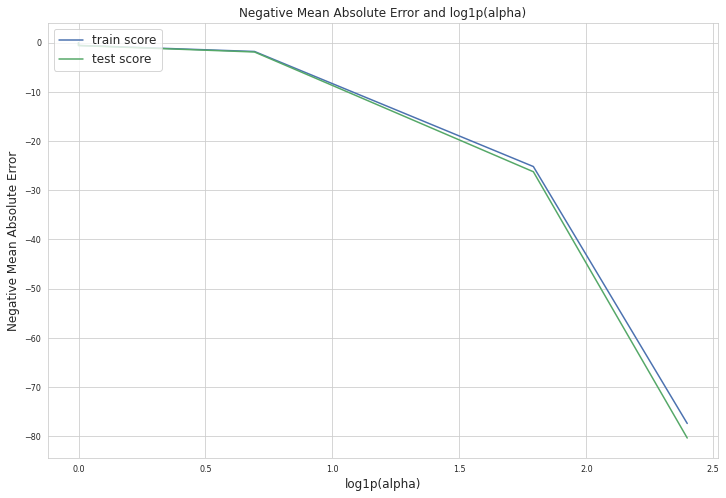

In [248]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.005, 0.01, 0.03, 0.05, 0.1, 0.5, 1.0, 5.0, 10]}
ridge = sklm.Ridge()

# cross validation
model_cv_ridge = skms.GridSearchCV(estimator = ridge, n_jobs=-1, param_grid = params, 
                             scoring= 'neg_mean_squared_error', cv = 5, 
                             return_train_score=True, verbose = 3)            
model_cv_ridge.fit(X_train_rfe, y_train)
plotCvResults(model_cv_ridge)

In [249]:
# verify log1p value for best selected alpha by GridSearch
print(model_cv_ridge.best_params_['alpha'])
print(np.log1p(model_cv_ridge.best_params_['alpha']))

0.0001
9.999500033330834e-05


## Lasso regression

In [250]:
lml = sklm.Lasso(alpha=0.01)
lml.fit(X_train_rfe, y_train)

# predict
y_train_pred = lml.predict(X_train_rfe)
print("Train r2:",skm.r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred = lml.predict(X_test_rfe)
print("Test r2:",skm.r2_score(y_true=y_test, y_pred=y_test_pred))

Train r2: 0.999965771900081
Test r2: 0.9999631590265303


Fitting 5 folds for each of 9 candidates, totalling 45 fits


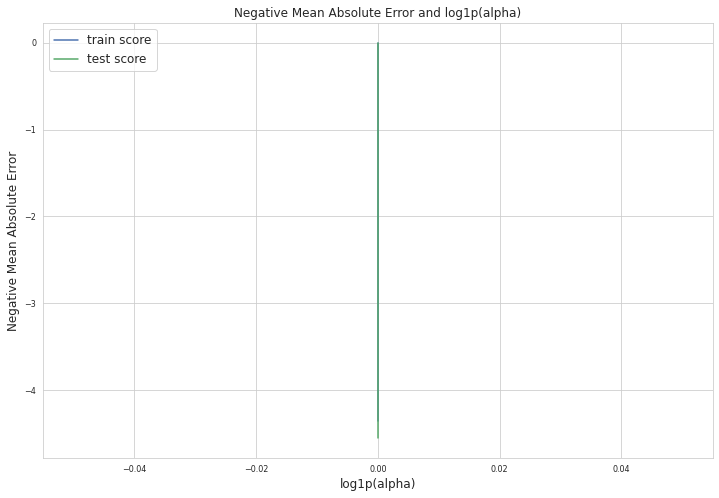

In [251]:
# list of alphas to tune
params = {'alpha': [0.00005, 0.0001, 0.0005, 0.0008, 0.001, 0.005, 0.01, 0.05, 0.1]}
lasso = sklm.Lasso()

# cross validation
model_cv_lasso = skms.GridSearchCV(estimator = lasso, n_jobs=-1, param_grid = params, 
                             scoring= 'neg_mean_squared_error', cv = 5, 
                             return_train_score=True, verbose = 3)            
model_cv_lasso.fit(X_train_rfe, y_train)
plotCvResults(model_cv_lasso)

In [252]:
# verify log1p value for best selected alpha by GridSearch
print(model_cv_lasso.best_params_['alpha'])
print(np.log1p(model_cv_lasso.best_params_['alpha']))

0.0005
0.000499875041651048


## Model Evaluation

In [253]:
# Ridge
alpha = model_cv_ridge.best_params_['alpha']
ridge_final = sklm.Ridge(alpha=alpha)

ridge_final.fit(X_train_rfe, y_train)
# bestParams(ridge_final)

Ridge(alpha=0.0001)

Train r2: 0.999999999992132
Test r2: 0.9999999999916434
Root Mean Square Error train: 0.00013777948094822746
Root Mean Square Error test: 0.00013643400828810458


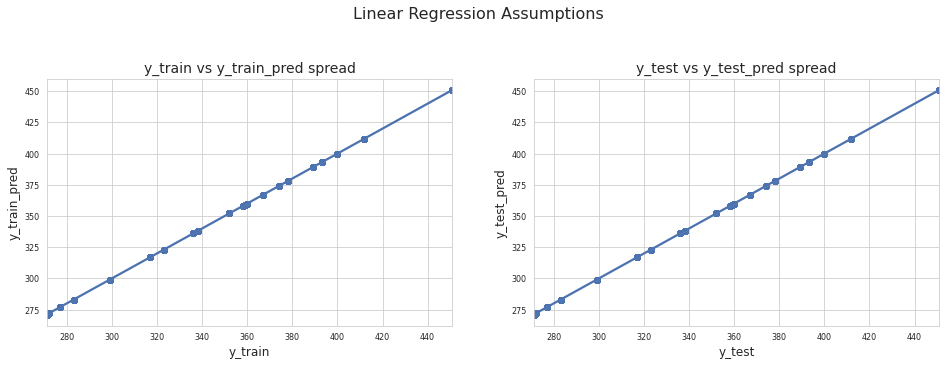

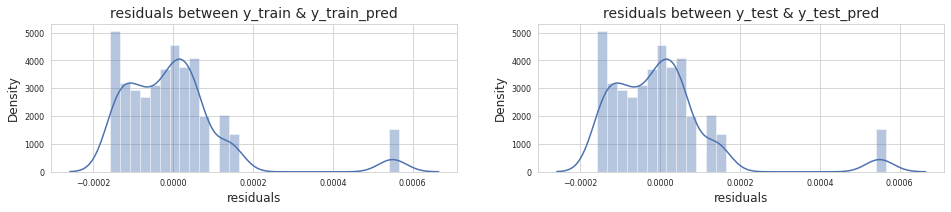

In [254]:
# r2 score for selected model
modelR2AndSpread(ridge_final)